In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib as mpl

import matplotlib.pyplot as plt
import numpy as np
from distgen import Generator
from distgen.physical_constants import unit_registry
from astra.astra_distgen import evaluate_astra_with_distgen
from pmd_beamphysics.plot import marginal_plot
import pickle

font = {
        'weight' : 'bold',
        'size'   : 20}

mpl.rc('font', **font)

In [2]:
!echo $ASTRA_BIN

/global/u1/l/lgupta/cori/GitHub/lume-astra/examples/Astra


In [1]:
!pwd

/global/u1/l/lgupta/cori/GitHub/lcls-sc-inj-surrogate/paper


## Loading in Distgen Inputs

In [3]:
VCC_IN = "files/2019_11_04_135614reg_outreg_laser_in.yaml"
VCC_FILTERED_IN = "files/2019_11_04_135614_filt_outfilt_laser_in.yaml"
SUPERG_IN = "files/2019_11_04_135614.yaml"
RMAX_IN = "files/135614-trunc-rmax.yaml"
CIRC = "files/135614_circ.yaml"
DIST_INPUTS = [RMAX_IN, VCC_IN, VCC_FILTERED_IN, SUPERG_IN, CIRC]
NAMES = ["RMAX", "VCC", "VCC_FILTERED", "SUPERG", "CIRC"]

In [4]:
def returnImportantStuff(input_file, bins = 100, nparticles = 1000):
    gen = Generator(input_file)
    gen.input['n_particle'] = nparticles
    gen.run()
    particles = gen.particles
    px = particles['x']
    py = particles['y']
    sig_x = particles['sigma_x']
    sig_y = particles['sigma_y']
    xhist = np.histogram(px, bins = bins)
    yhist = np.histogram(py, bins = bins)
    H, xedges, yedges = np.histogram2d(px, py, bins=bins)
    return particles, xhist, yhist, H

## View the Distgen Inputs

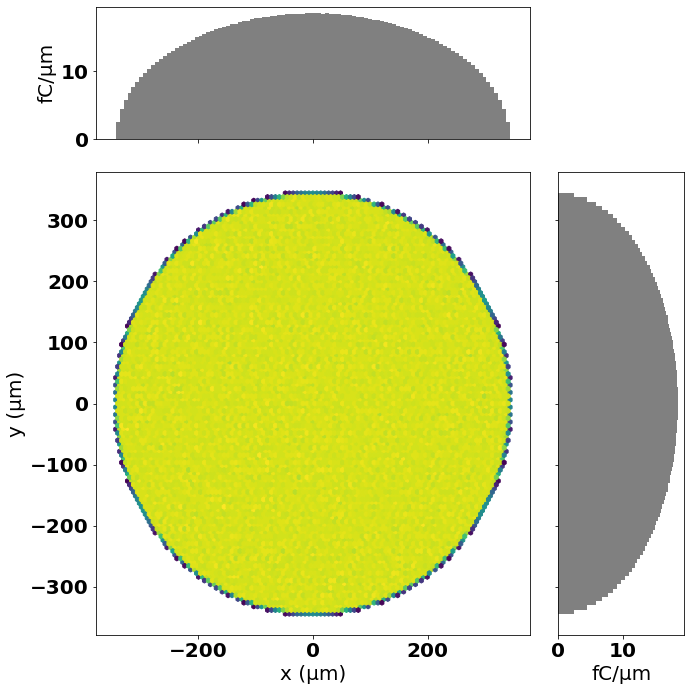

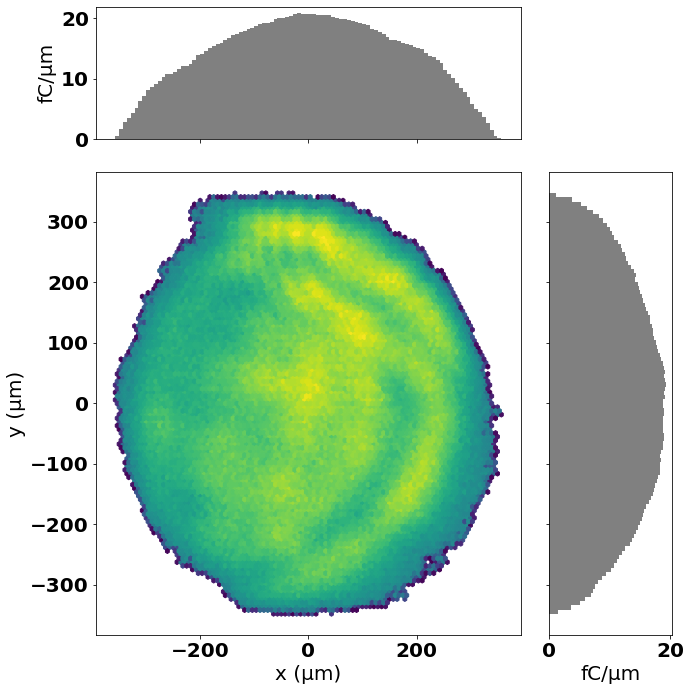

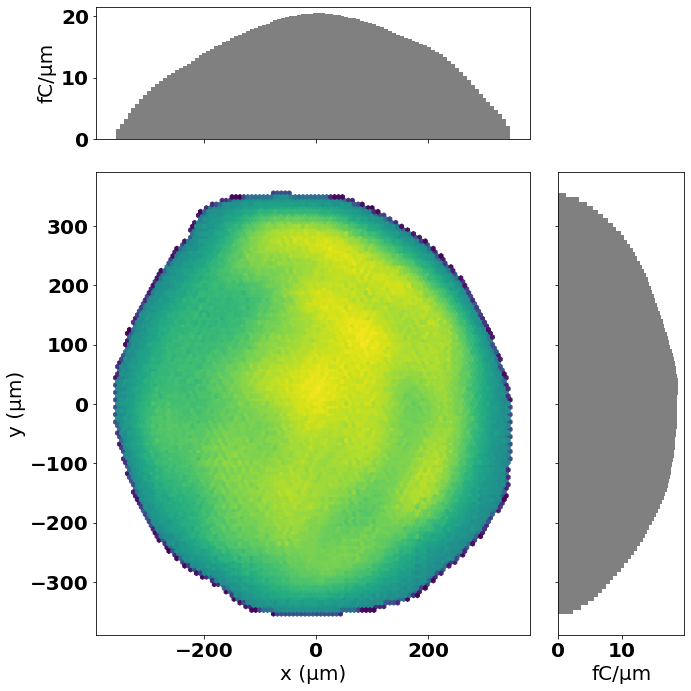

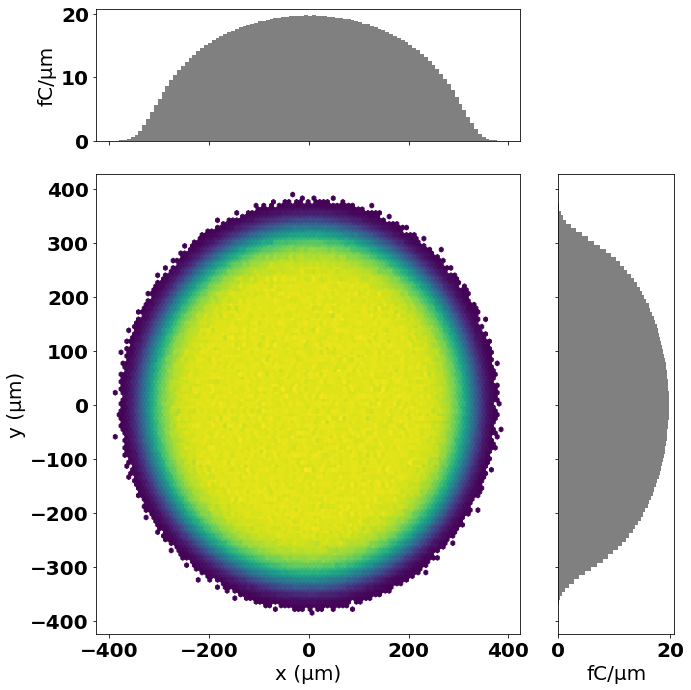

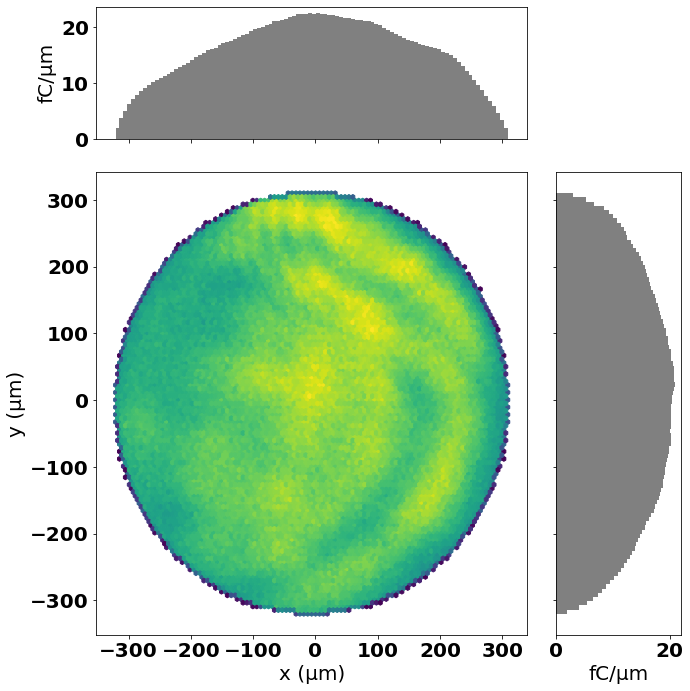

In [13]:
i = 0
for inp in DIST_INPUTS:
    name = NAMES[i]
    mpl.rcParams['figure.figsize'] = (10,10)
    particles, hx, hy, H= returnImportantStuff(inp, bins = 100, nparticles = 1000000)
    marginal_plot(particles, 'x', 'y', bins = 100)
    plt.savefig("figures/"+name+"_1m.png")
    plt.tight_layout()
    plt.show()
    i = i+1

## Run Astra

Change Astra input and archive directories as needed.

In [6]:
ASTRA_IN = "/global/homes/l/lgupta/cori/GitHub/lcls-lattice/astra/models/gunb_eic/astra.in"
ARCHIVE_PATH = "/global/u1/l/lgupta/m669/datasets/temp"

In [7]:
#0.07*(0.1342*(1/10**(-4))*10**-3)

In [22]:
settings = {}
settings["High Charge = 50pC"] = {"distgen:n_particle": 10000, "lspch": True, "zstop": 1.49, "phi(1)": 0 , "maxb(2)": 0.07 , 
             "distgen:total_charge:value": 50.0 , "zphase": 20}
settings["Low Charge = 5pC"] = {"distgen:n_particle": 10000, "lspch": True, "zstop": 1.49, "phi(1)": 0 , "maxb(2)": 0.07 , 
             "distgen:total_charge:value": 5.0 , "zphase": 20}



charges = ["High Charge = 50pC", "Low Charge = 5pC"]

outputs = {}
for charge in charges:
    settings0 = settings[charge]
    all_outputs = {}
    for i, inp in enumerate(DIST_INPUTS):
        A = evaluate_astra_with_distgen(settings0, astra_input_file=ASTRA_IN,
                    distgen_input_file=inp, verbose= False , archive_path = ARCHIVE_PATH)
        all_outputs[NAMES[i]] = A
    outputs[charge] = all_outputs

with open('charge_scan.pickle', 'wb') as handle:
    pickle.dump(outputs, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Done")

# with open('charge_scan.pickle', 'rb') as handle:
#     outputs = pickle.load(handle, encoding= 'unicode')
# print("Done")

Done


In [25]:

emits = ["end_core_emit_95percent_x", "end_core_emit_95percent_y"]
emit_names = {"end_core_emit_95percent_x": "$\epsilon_{n 95\%, x} $", 
                 "end_core_emit_95percent_y": "$\epsilon_{n 95\%, y} $"}

sizes = ['end_sigma_x', 'end_sigma_y']
size_names = {'end_sigma_x': "$\sigma_{x}$", 
             'end_sigma_y': "$\sigma_{y}$"}

NAMES = ["RMAX","VCC", "VCC_FILTERED", "SUPERG", "CIRC"]
plot_names = ["Uniform", "VCC", "VCC - G. Blur", "Super Guassian",  "VCC - Circle"] 

## View the Results

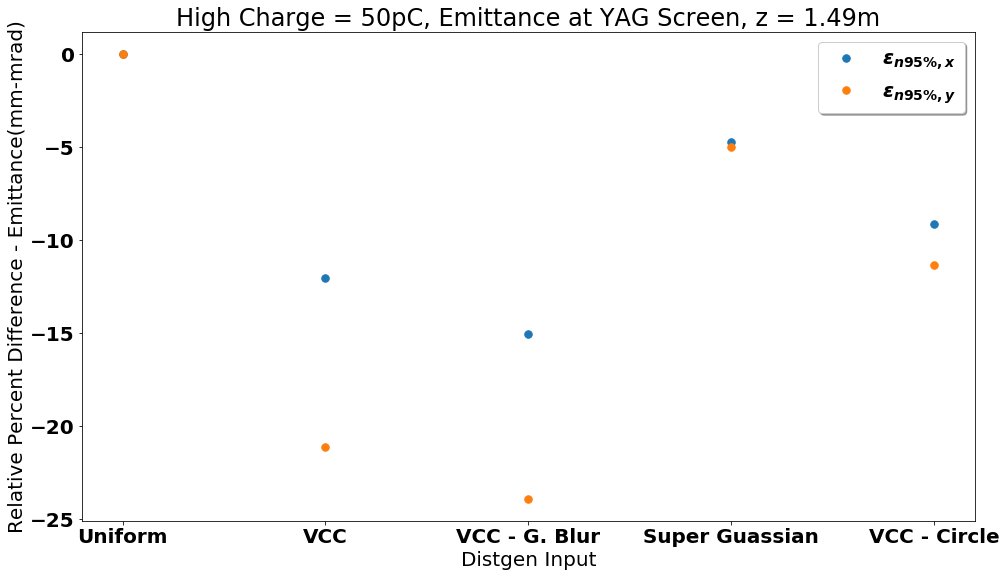

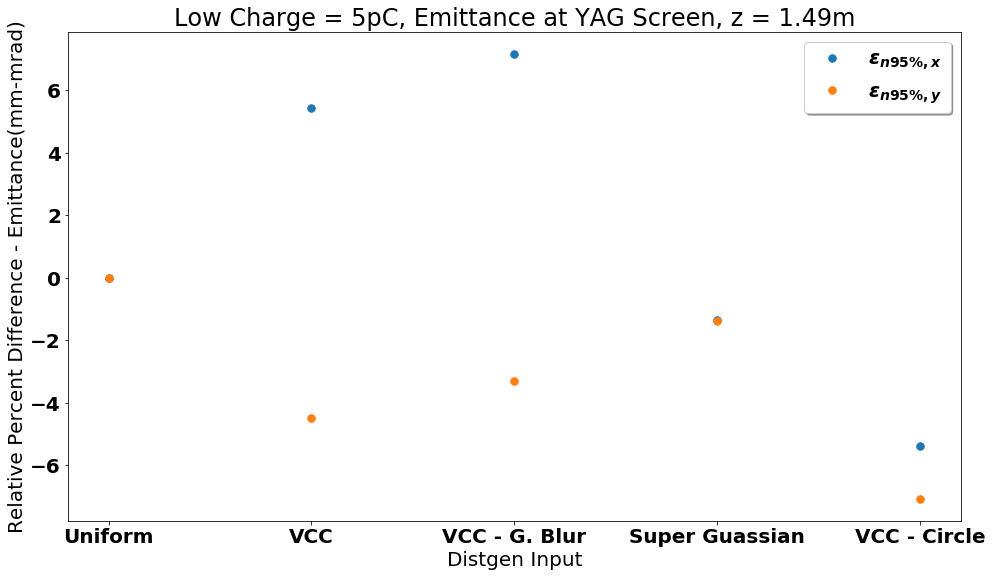

In [28]:
norm = {}
for charge in charges:
    d = {}
    for e in emits:
        d[e] = outputs[charge]["RMAX"][e]
    norm[charge] = d

for charge in charges:
    plt.figure(figsize = (16,9))
    for e in emits:
        em = []
        for name in NAMES:
            em.append(outputs[charge][name][e]/norm[charge][e])
        
        plt.title(e)
        plt.plot(plot_names, 100*np.array(em) - 100, '.', label = emit_names[e], markersize = 15)
        plt.legend(fontsize=20, fancybox = True, shadow = True, frameon = True)
    plt.xlabel("Distgen Input")
    plt.ylabel("Relative Percent Difference - Emittance(mm-mrad)")
    plt.title(charge + ", Emittance at YAG Screen, z = 1.49m")
    plt.savefig("figures/" + charge.split(" ")[0] + "_charge_emit.png")
    plt.show()

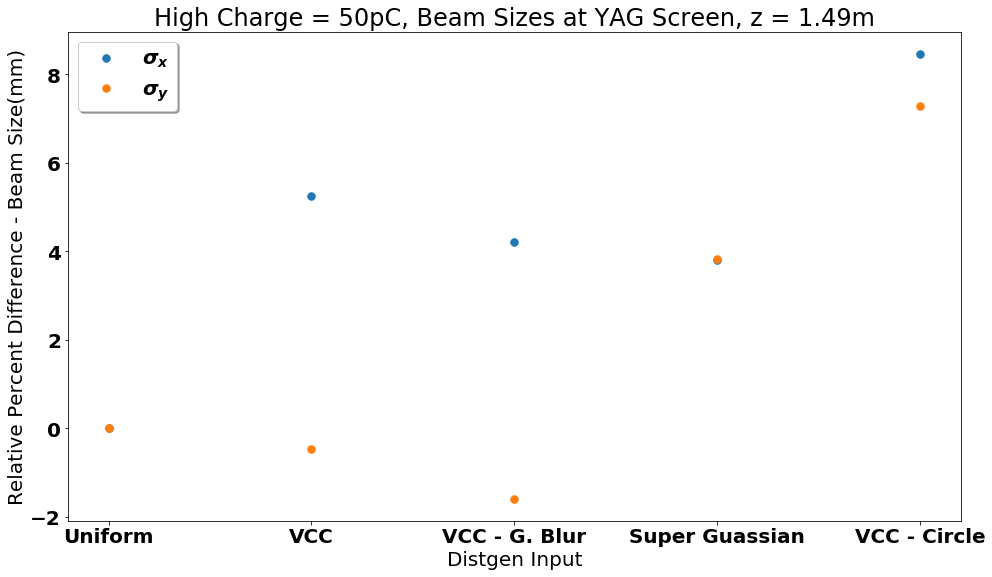

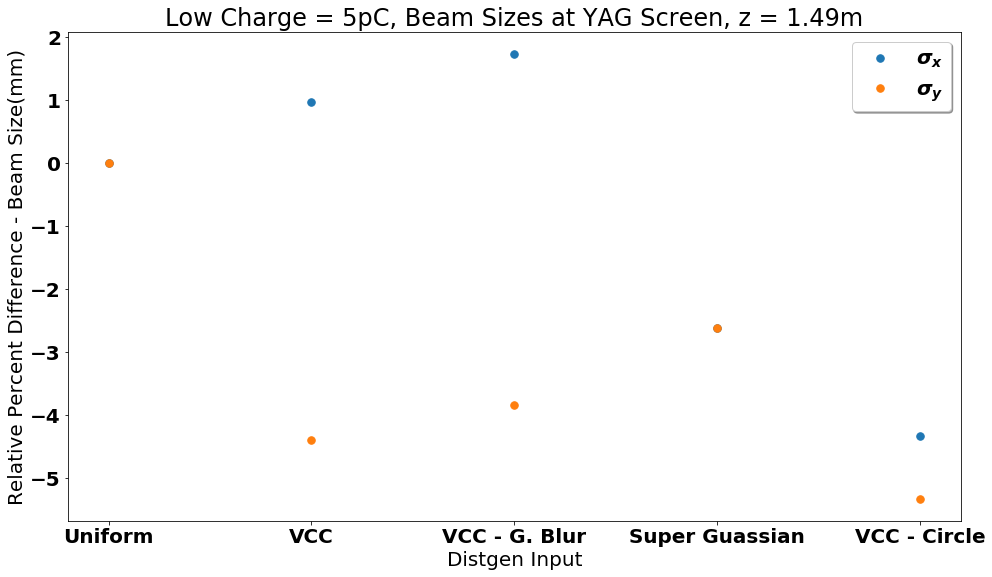

In [29]:
norm = {}
for charge in charges:
    d = {}
    for e in sizes:
        d[e] = outputs[charge]["RMAX"][e]
    norm[charge] = d

    
for charge in charges:
    plt.figure(figsize = (16,9))
    for e in sizes:
        em = []
        for name in NAMES:
            em.append(outputs[charge][name][e]/norm[charge][e])
        plt.title(e)
        plt.plot(plot_names, 100*np.array(em)-100, '.', label = size_names[e], markersize = 15)
        plt.legend(fontsize=20, fancybox = True, shadow = True, frameon = True)
    plt.xlabel("Distgen Input")
    plt.ylabel("Relative Percent Difference - Beam Size(mm)")
    plt.title(charge + ", Beam Sizes at YAG Screen, z = 1.49m")
    plt.savefig("figures/" + charge.split(" ")[0] + "_charge_beamsize.png")
    plt.show()

## Run Again near Beam Waist (for ~20 pC)

In [ ]:
settings = {}
settings["High Charge = 250pC"] = {"distgen:n_particle": 10000, "lspch": True, "zstop": 1.49, "phi(1)": 0 , "maxb(2)": 0.06 , 
             "distgen:total_charge:value": 250.0 , "zphase": 20}
settings["Low Charge = 25pC"] = {"distgen:n_particle": 10000, "lspch": True, "zstop": 1.49, "phi(1)": 0 , "maxb(2)": 0.06 , 
             "distgen:total_charge:value": 25.0 , "zphase": 20}

NAMES = ["VCC", "VCC_FILTERED", "SUPERG", "RMAX", "CIRC"]

charges = ["High Charge = 250pC", "Low Charge = 25pC"]

sol_outputs = {}
for charge in charges:
    settings0 = settings[charge]
    all_outputs = {}
    for i, inp in enumerate(DIST_INPUTS):
        A = evaluate_astra_with_distgen(settings0, astra_input_file=ASTRA_IN,
                    distgen_input_file=inp, verbose= False , archive_path = ARCHIVE_PATH)
        all_outputs[NAMES[i]] = A
    sol_outputs[charge] = all_outputs

with open('nearwaist_charge_scan.pickle', 'wb') as handle:
    pickle.dump(sol_outputs, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Done")



In [ ]:
norm = {}
for charge in charges:
    d = {}
    for e in emits:
        d[e] = sol_outputs[charge]["RMAX"][e]
    norm[charge] = d

for charge in charges:
    for e in emits:
        em = []
        for name in NAMES:
            em.append(sol_outputs[charge][name][e]/norm[charge][e])
        plt.title(e)
        plt.plot(plot_names, 100*np.array(em)-100, '.', label = emit_names[e], markersize = 15)
        plt.legend(fontsize=20, shadow=True, frameon = True, fancybox = True)
    plt.xlabel("Distgen Input")
    plt.ylabel("Relative Percent Difference - Emittance(mm-mrad)")
    plt.title(charge + ", Emittance at YAG Screen, z = 1.49m")
    plt.savefig("figures/" + charge.split(" ")[0] + "_charge_sol_emit.png")
    plt.show()

In [ ]:
norm = {}
for charge in charges:
    d = {}
    for e in sizes:
        d[e] = sol_outputs[charge]["RMAX"][e]
    norm[charge] = d
    
for charge in charges:
    for e in sizes:
        em = []
        for name in NAMES:
            em.append(sol_outputs[charge][name][e]/norm[charge][e])
        plt.title(e)
        plt.plot(plot_names, 100*np.array(em)-100, '.', label = size_names[e], markersize = 15)
        plt.legend(fontsize=20, shadow=True, frameon = True, fancybox = True)
        
    plt.xlabel("Distgen Input")
    plt.ylabel("Relative Percent Difference - Beam Size(mm)")
    plt.title(charge + ", Beam Sizes at YAG Screen, z = 1.49m")
    plt.savefig("figures/" + charge.split(" ")[0] + "_charge_sol_beamsize.png")
    plt.show()

## Run again with solenoid field in mid-range of experimental values

In [ ]:
settings = {}
settings["High Charge = 250pC"] = {"distgen:n_particle": 10000, "lspch": True, "zstop": 1.49, "phi(1)": 0 , "maxb(2)": 0.075 , 
             "distgen:total_charge:value": 250.0 , "zphase": 20}
settings["Low Charge = 25pC"] = {"distgen:n_particle": 10000, "lspch": True, "zstop": 1.49, "phi(1)": 0 , "maxb(2)": 0.075 , 
             "distgen:total_charge:value": 25.0 , "zphase": 20}

NAMES = ["VCC", "VCC_FILTERED", "SUPERG", "RMAX", "CIRC"]

charges = ["High Charge = 250pC", "Low Charge = 25pC"]

sol2_outputs = {}
for charge in charges:
    settings0 = settings[charge]
    all_outputs = {}
    for i, inp in enumerate(DIST_INPUTS):
        A = evaluate_astra_with_distgen(settings0, astra_input_file=ASTRA_IN,
                    distgen_input_file=inp, verbose= False , archive_path = ARCHIVE_PATH)
        all_outputs[NAMES[i]] = A
    sol2_outputs[charge] = all_outputs

with open('operationrange_charge_scan.pickle', 'wb') as handle:
    pickle.dump(sol2_outputs, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Done")

In [ ]:
norm = {}
for charge in charges:
    d = {}
    for e in emits:
        d[e] = sol2_outputs[charge]["RMAX"][e]
    norm[charge] = d
    
for charge in charges:
    for e in emits:
        em = []
        for name in NAMES:
            em.append(sol2_outputs[charge][name][e]/norm[charge][e])
        mpl.style.use('seaborn')
        plt.title(e)
        plt.plot(plot_names, 100*np.array(em)-100, '.', label = emit_names[e], markersize = 15)
        plt.legend(fontsize=20, shadow=True, frameon = True, fancybox = True)
    plt.xlabel("Distgen Input")
    plt.ylabel("Relative Percent Difference - Emittance(mm-mrad)")
    plt.title(charge + ", Emittance at YAG Screen, z = 1.49m")
    plt.savefig("figures/" + charge.split(" ")[0] + "_charge_sol2_emit.png")
    plt.show()

In [ ]:
norm = {}
for charge in charges:
    d = {}
    for e in sizes:
        d[e] = sol2_outputs[charge]["RMAX"][e]
    norm[charge] = d
    
for charge in charges:
    for e in sizes:
        em = []
        for name in NAMES:
            em.append(sol2_outputs[charge][name][e]/norm[charge][e])
        mpl.style.use('seaborn')
        plt.title(e)
        plt.plot(plot_names, 100*np.array(em)-100, '.', label = size_names[e], markersize = 15)
        plt.legend(fontsize=20, shadow=True, frameon = True, fancybox = True)
    plt.xlabel("Distgen Input")
    plt.ylabel("Relative Percent Difference - Beam Size(mm)")
    plt.title(charge + ", Beam Sizes at YAG Screen, z = 1.49m")
    plt.savefig("figures/" + charge.split(" ")[0] + "_charge_sol2_beamsize.png")
    plt.show()